In [1]:
import psutil
print(f"Memory usage before simulation: {psutil.virtual_memory().percent}%")

# 启用多进程 spawn 模式
import multiprocessing as mp
mp.set_start_method('spawn', force=True)

# 清理 GPU 缓存（如果使用 GPU）
import torch
torch.cuda.empty_cache()

import sys
import os
os.environ["HOLOOCEAN_CONFIG_PATH"] = "/sciclone/home/dyang06/.local/share/holoocean/1.0.0/worlds/Ocean/config.json"
import torch.multiprocessing as mp
from auv_planning.parallel_train import parallel_train
print(sys.path)
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation
import seaborn as sns
import numpy as np

import holoocean

from tqdm import tqdm

from auv_planning.estimation import InEKF
from auv_planning.control import LQR
from auv_planning.planning.LQR_SAC_V_O import LQRSACPlanner
from auv_planning.planning.Dijkstras import Dijkstra
from auv_planning.planning.astar import Astar
from auv_planning.planning.aco_astar import ACO_AStar
from auv_planning.planning import Traj, RRT
from auv_planning import State
from plotter import Plotter
from auv_planning import scenario
sns.set(context="paper", style="whitegrid", font_scale=0.8)

from mpl_toolkits.mplot3d import Axes3D

class Plotter:
    def __init__(self, names):
        # Where all the data is stored
        self.t = []
        self.data = None

        self.num_row = 5
        self.num_col = 3
        self.num_items = len(names)

        # Setup figure
        self.fig, self.ax = plt.subplots(
            self.num_row, self.num_col, figsize=(6, 8), sharex=True
        )

        # Setup all lines
        self.lines = [[[] for _ in range(self.num_row)] for _ in range(len(names))]
        for i in range(self.num_row):
            for j in range(self.num_col):
                for k, n in enumerate(names):
                    (p,) = self.ax[i, j].plot([], [], label=n)
                    self.lines[k][i].append(p)

        self.ax[-1, 2].legend()

        # Add axes labels
        titles = ["Position", "Velocity", "RPY", "Bias - Omega", "Bias - Acceleration"]
        for i in range(self.num_row):
            self.ax[i, 1].set_title(titles[i])
        self.fig.tight_layout()
        plt.savefig("layout.png")
        
        plt.ion()
        # Additional setup for 3D plot
        self.fig_3d = plt.figure(figsize=(8, 6))
        self.ax_3d = self.fig_3d.add_subplot(111, projection='3d')
        self.ax_3d.set_title("AUV 3D Trajectory")
        self.ax_3d.set_xlabel("X Position (m)")
        self.ax_3d.set_ylabel("Y Position (m)")
        self.ax_3d.set_zlabel("Z Position (m)")

    def add_timestep(self, t, states):
        # Keep the time
        self.t.append(t)

        # Plop our data at the end of the other data
        new_state = np.stack([s.data_plot for s in states])

        if self.data is None:
            # Initialize self.data if it hasn't been initialized yet
            self.data = new_state[:, :, np.newaxis]
        else:
            # Concatenate new data along the third axis
            self.data = np.concatenate((self.data, new_state[:, :, np.newaxis]), axis=2)

    def _rot_to_rpy(self, mat):
        return Rotation.from_matrix(mat).as_euler("xyz")

    def update_plots(self):
        # Update all lines
        for i in range(self.num_row):
            for j in range(self.num_col):
                for k in range(self.num_items):
                    # Ensure that the data is correctly indexed to provide a sequence
                    if self.num_col * i + j < self.data.shape[1]:
                        y_data = self.data[k, self.num_col * i + j, :]
                        # Check if y_data length matches the length of t
                        if len(self.t) == y_data.shape[0] and not (np.any(np.isnan(y_data)) or np.any(np.isinf(y_data))):
                            self.lines[k][i][j].set_data(self.t, y_data)

                self.ax[i, j].relim()
                self.ax[i, j].autoscale_view()

        # Update 3D trajectory plot
        for k in range(self.num_items):
            x_data = self.data[k, 0, :]  # X positions
            y_data = self.data[k, 1, :]  # Y positions
            z_data = self.data[k, 2, :]  # Z positions (height)
            if len(self.t) == x_data.shape[0]:
                self.ax_3d.plot(x_data, y_data, z_data, label=f"{k}-{self.lines[k][0][0].get_label()}")
            
            # Plot start and end points
            if k == 0 and len(x_data) > 0:
                self.ax_3d.scatter(
                    x_data[0], y_data[0], z_data[0], c='green', marker='o', s=100, label=f"{self.lines[k][0][0].get_label()} Start" if k == 0 else None
                )
                self.ax_3d.scatter(
                    x_data[-1], y_data[-1], z_data[-1], c='red', marker='x', s=100, label=f"{self.lines[k][0][0].get_label()} End" if k == 0 else None
                )

        self.ax_3d.legend()

        # Display the updated plot in Jupyter
        plt.show()
        print("Plot updated in Jupyter Notebook.")

# Main function to run the simulation
def main(num_seconds=100, show=False, plot=True, verbose=False, route="rrt", num_workers=10, num_episodes=200,ctrain = False,max_step = 1000,model_path="",obsname ="",BS = 1024):
    if "Ocean" not in holoocean.installed_packages():
        print("ssss")
        holoocean.install("Ocean")
    print("ssss1")
    # Load in HoloOcean info
    ts = 1 / scenario["ticks_per_sec"]
    num_ticks = int(num_seconds / ts)

    # Set everything up
    controller = LQR()
    observer = InEKF()
    print("ssss2")
    dummy_env = holoocean.make(scenario_cfg=scenario, show_viewport=False, verbose=verbose)
    print("sss3")
    if route == "rrt":
        planner = RRT(num_seconds)
        print("this RRT way")
    elif route == "astar":
        planner = Astar(num_seconds)
        print("this Astar way")
    elif route == "djs":
        planner = Dijkstra(num_seconds)
        print("this Dijkstra way")
    elif route == "aco":
        planner = ACO_AStar(num_seconds)
        print("this ACO_AStar way")
    elif route == "sac":
        planner = LQRSACPlanner(num_seconds, batch_size = BS )
        print("Using PPO planner")
        
        
        if not os.path.exists(model_path):
            planner.train(dummy_env, num_episodes=num_episodes, max_steps = max_step, model_path = model_path, obsname = obsname )
        elif ctrain:
            planner.load_model(model_path)
            new_path = 'ctrain_'+ model_path
            planner.train(dummy_env, num_episodes=num_episodes, max_steps = max_step, model_path = new_path)
            #parallel_train(planner, num_episodes, num_workers, verbose,scenario)

    else:
        planner = Traj(route, num_seconds)
        print("this way")
    if plot:
        plotter = Plotter(["True", "Estimated", "Desired"])

    # # Run simulation!
    # u = np.zeros(8)
    # des_action = np.zeros(8)
    # env = dummy_env
    # env.set_render_quality(0)
    # env.reset()
    # if route == "sac":
    #     planner.load_model(model_path)  # 加载模型
    #     planner.setup_obstacles()
    #     planner.draw_traj(env, num_seconds)
    #     env.act("auv0", u)
    #     done = False
    #     sensors = env.tick()
    #     # Pluck true state from sensors
    #     t = sensors["t"]
    #     for i in tqdm(range(num_ticks)):
    #         true_state = State(sensors)
    #         d_g, d_n_o = planner.extract_element(true_state)
    #         if d_g < 5:
    #             done = True
    #         true_state_for_planner = np.append(true_state.vec[0:], true_state.bias[0:])
    #         #true_state_for_planner = np.append(true_state_for_planner, true_state.mat[0:])
    #         true_state_for_planner = np.append(true_state_for_planner, d_g)
    #         true_state_for_planner = np.append(true_state_for_planner, d_n_o)
    #         true_state_for_planner = np.append(true_state_for_planner, done)
    #         #real_next_state = State(real_next_state)
    #         # Estimate State
    #         est_state = observer.tick(sensors, ts)

    #         # Path planner

    #         des_action = planner.select_action(true_state_for_planner,inference = True)
    #         env.act("auv0", des_action)
    #         sensors = env.tick()

    #         # Pluck true state from sensors
    #         t = sensors["t"]
    #         des_state = State(sensors)
    #         # Autopilot Commands
    #         u = controller.u(est_state, des_state)
    #         # Update visualization
    #         if plot:
    #             plotter.add_timestep(t, [true_state, est_state, des_state])
    #         if done:
    #             break                
    # else:
    #     for i in tqdm(range(num_ticks)):
    #         # Tick environment
    #         env.act("auv0", u)
    #         sensors = env.tick()

    #         # Pluck true state from sensors
    #         t = sensors["t"]
    #         true_state = State(sensors)

    #         # Estimate State
    #         est_state = observer.tick(sensors, ts)

    #         # Path planner

    #         des_state = planner.tick(t)

    #         # Autopilot Commands
    #         u = controller.u(est_state, des_state)
    #         #print(u)
    #         # Update visualization
    #         if plot:
    #             plotter.add_timestep(t, [true_state, est_state, des_state])

    # # Final plot update after all data is collected
    # if plot:
    #     plotter.update_plots()

Memory usage before simulation: 8.0%
['/sciclone/home/dyang06/DecisionMK/AUVControl', '/sciclone/home/dyang06/anaconda3/envs/Path/lib/python39.zip', '/sciclone/home/dyang06/anaconda3/envs/Path/lib/python3.9', '/sciclone/home/dyang06/anaconda3/envs/Path/lib/python3.9/lib-dynload', '', '/sciclone/home/dyang06/anaconda3/envs/Path/lib/python3.9/site-packages', '/sciclone/home/dyang06/anaconda3/envs/Path/lib/python3.9/site-packages/setuptools/_vendor']


In [21]:
import numpy as np

a = [51,51,-5]
end = [50,50,-20]
c = np.array(end) - np.array(a)

b =np.linalg.norm(c)

print(b)

nmc = c / (b+1e-7)

print(nmc)

15.066519173319364
[-0.06637233 -0.06637233 -0.99558496]


In [ ]:

if __name__ == "__main__":
    #mp.set_start_method('spawn')  # 为多进程设置启动方法
    main(num_seconds=400, show=False, plot=True, verbose=False, route="sac", num_workers=1, num_episodes=20000,ctrain = False, max_step = 512, model_path = 'Nm_add_a_SAC512_bs128_r12_1217_md_21sd.pth',obsname = "new_obs0_",BS = 128)
    print("separated space \n")

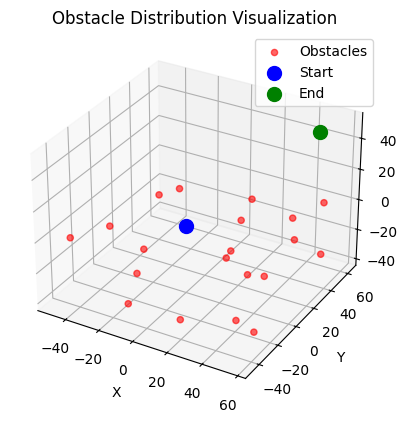

In [1]:
def visualize_obstacle_distribution(filename, start=None, end=None):
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    # 加载障碍物分布
    with open(filename, 'rb') as f:
        obstacle_distributions = pickle.load(f)
    
    obstacle_distributions = np.array(obstacle_distributions)
    obstacle_distributions = obstacle_distributions[0]
    # 创建 3D 图形
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # 绘制障碍物
    ax.scatter(obstacle_distributions[:, 0], 
               obstacle_distributions[:, 1], 
               obstacle_distributions[:, 2], 
               c='red', label='Obstacles', alpha=0.6)
    
    # 设置起点和终点
    if start is not None:
        ax.scatter(start[0], start[1], start[2], c='blue', label='Start', s=100)
    if end is not None:
        ax.scatter(end[0], end[1], end[2], c='green', label='End', s=100)
    
    # 设置标签和标题
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Obstacle Distribution Visualization')
    plt.legend()
    plt.show()

# 示例调用
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
visualize_obstacle_distribution("new_obs4_SAC_512_train_obstacles.pkl", start=np.array([0, 0, 0]), end=np.array([50, 50, 50]))

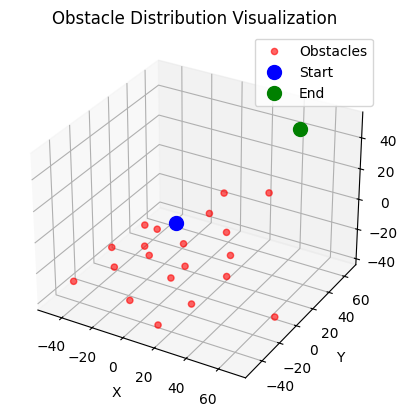

In [2]:
def visualize_obstacle_distribution(filename, start=None, end=None):
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    # 加载障碍物分布
    with open(filename, 'rb') as f:
        obstacle_distributions = pickle.load(f)
    
    obstacle_distributions = np.array(obstacle_distributions)
    obstacle_distributions = obstacle_distributions[1]
    # 创建 3D 图形
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # 绘制障碍物
    ax.scatter(obstacle_distributions[:, 0], 
               obstacle_distributions[:, 1], 
               obstacle_distributions[:, 2], 
               c='red', label='Obstacles', alpha=0.6)
    
    # 设置起点和终点
    if start is not None:
        ax.scatter(start[0], start[1], start[2], c='blue', label='Start', s=100)
    if end is not None:
        ax.scatter(end[0], end[1], end[2], c='green', label='End', s=100)
    
    # 设置标签和标题
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Obstacle Distribution Visualization')
    plt.legend()
    plt.show()

# 示例调用
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
visualize_obstacle_distribution("new_obs4_SAC_512_train_obstacles.pkl", start=np.array([0, 0, 0]), end=np.array([50, 50, 50]))

# debug RL

Iteration 1/10, Best Path Length: 86.31202762478185
Iteration 2/10, Best Path Length: 86.31202762478185
Iteration 3/10, Best Path Length: 86.31202762478185
Iteration 4/10, Best Path Length: 86.31202762478185
Iteration 5/10, Best Path Length: 86.31202762478185
Iteration 6/10, Best Path Length: 86.31202762478185
Iteration 7/10, Best Path Length: 86.31202762478185
Iteration 8/10, Best Path Length: 86.31202762478185
Iteration 9/10, Best Path Length: 86.31202762478185
Iteration 10/10, Best Path Length: 86.31202762478185
this ACO_AStar way


100%|████████████████████████████████████| 10000/10000 [00:39<00:00, 251.80it/s]


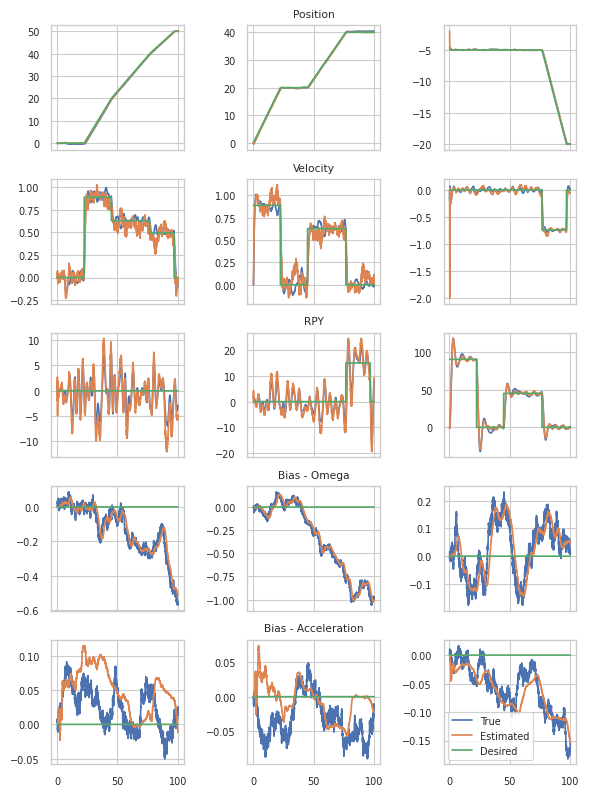

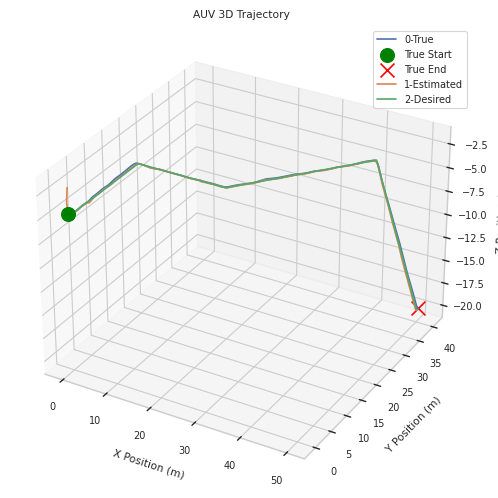

Plot updated in Jupyter Notebook.


In [4]:
main(num_seconds=100, show=False, plot=True, verbose=False,route="aco")

this Dijkstra way


100%|████████████████████████████████████| 10000/10000 [00:40<00:00, 247.68it/s]


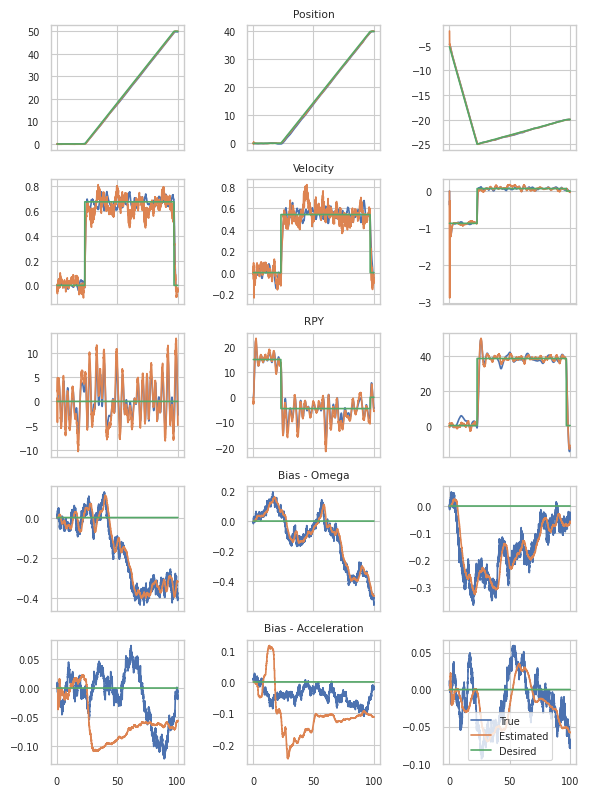

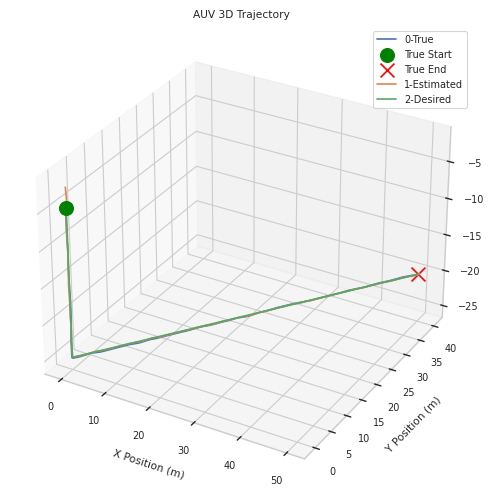

Plot updated in Jupyter Notebook.


In [4]:
main(num_seconds=100, show=False, plot=True, verbose=False,route="djs")

In [4]:
main(num_seconds=100, show=False, plot=True, verbose=False,route="astar")

KeyboardInterrupt: 

this RRT way


100%|████████████████████████████████████| 10000/10000 [00:39<00:00, 250.83it/s]


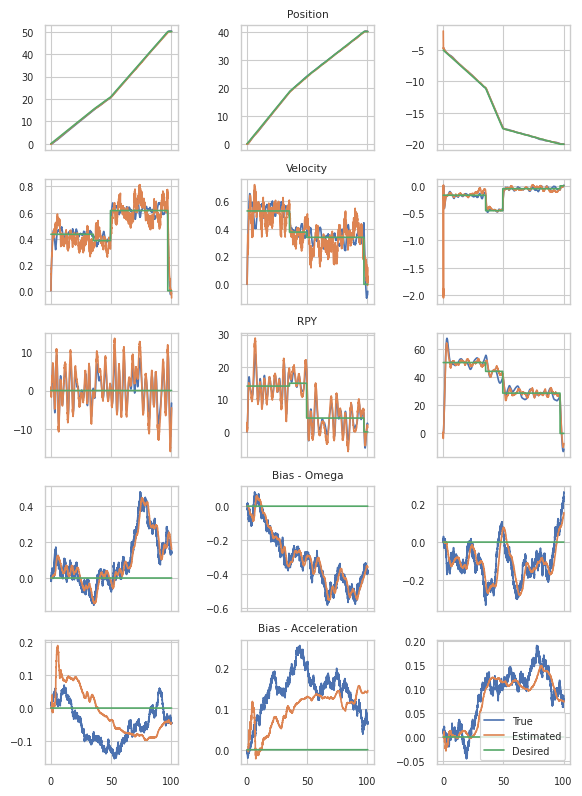

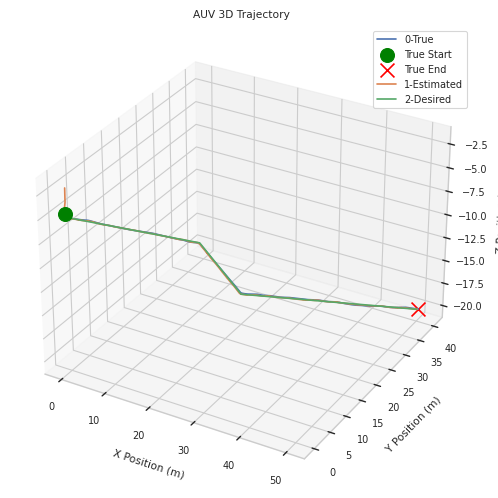

Plot updated in Jupyter Notebook.


In [5]:
main(num_seconds=100, show=False, plot=True, verbose=False,route="rrt")

2